In [1]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime

from sklearn.preprocessing import MinMaxScaler

%load_ext tensorboard
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)
    
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = (size - train_size) // 2
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

In [3]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'sentiment_polarity', 'close']]
data.columns.values[7] = "y"
data.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.9112


In [4]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,sentiment_polarity,y
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,33.0411
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.1300
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.0006
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,32.9112
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.8800


# Split dataset

In [5]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11796, 8)
Train dataset shape: (9436, 8)
Cross validation dataset shape: (1180, 8)
Dev dataset shape: (1180, 8)


# Stock prices graph

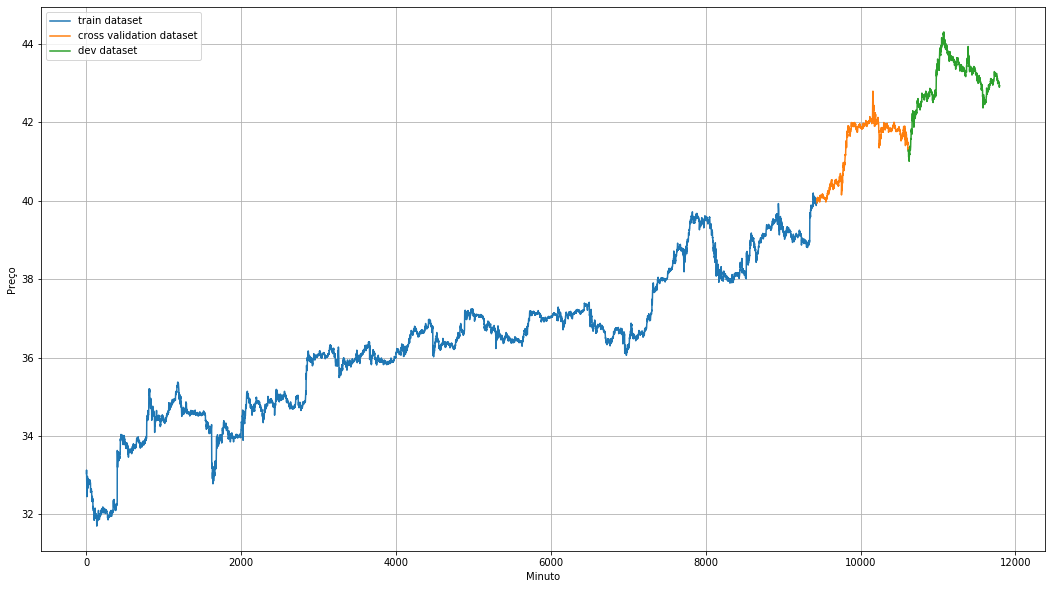

In [6]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='upper left')

# Data normalization

In [7]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])

train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

# Create window dataset

In [16]:
WINDOW_SIZE = 10
BATCH_SIZE = 64

windowed_dataset_train, labels_train = create_window_dataset(train_dataset[:, 0:-1], train_dataset[:, -1], WINDOW_SIZE)

windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)
# unshuffled_cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

# for dev set the batch size needs to fit the data
# https://stackoverflow.com/questions/54159034/what-if-the-sample-size-is-not-divisible-by-batch-size-in-keras-model
windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
# for i in range(1,160):
#     if windowed_dataset_dev.shape[0] % i == 0:
#         dev_batch = i
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

# Train model

In [17]:
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)
DEV_STEP = windowed_dataset_dev.shape[0]

In [18]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=windowed_dataset_train.shape[-2:]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(192, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                             decay_steps=1000000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['mae'])

class StopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') < 0.2):
            print("\nReached the desired validation error so cancelling training!")
            self.model.stop_training = True

stop_callback = StopCallback()

log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(train_set,
                    epochs=1500,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=cross_validation_set,
                    validation_steps=VALIDATION_STEP,
                    verbose=1,
                    callbacks=[stop_callback])

Train for 148 steps, validate for 19 steps
Epoch 1/1500
148/148 [==============================] - 6s 42ms/step - loss: 134.4176 - mae: 7.6223 - val_loss: 15.9861 - val_mae: 3.9389
Epoch 2/1500
148/148 [==============================] - 2s 11ms/step - loss: 20.7631 - mae: 3.6200 - val_loss: 10.2855 - val_mae: 3.1504
Epoch 3/1500
148/148 [==============================] - 2s 11ms/step - loss: 16.9021 - mae: 3.2716 - val_loss: 5.1327 - val_mae: 2.2031
Epoch 4/1500
148/148 [==============================] - 2s 11ms/step - loss: 14.3889 - mae: 3.0025 - val_loss: 7.1861 - val_mae: 2.6314
Epoch 5/1500
148/148 [==============================] - 2s 11ms/step - loss: 12.3206 - mae: 2.7685 - val_loss: 8.0966 - val_mae: 2.8062
Epoch 6/1500
148/148 [==============================] - 2s 11ms/step - loss: 11.7304 - mae: 2.7034 - val_loss: 2.3176 - val_mae: 1.4548
Epoch 7/1500
148/148 [==============================] - 2s 11ms/step - loss: 10.8977 - mae: 2.6055 - val_loss: 1.9043 - val_mae: 1.3148
Ep

148/148 [==============================] - 2s 11ms/step - loss: 4.5806 - mae: 1.6274 - val_loss: 1.9335 - val_mae: 1.3538
Epoch 61/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.6342 - mae: 1.6522 - val_loss: 1.5198 - val_mae: 1.1898
Epoch 62/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.5497 - mae: 1.6219 - val_loss: 1.1545 - val_mae: 1.0272
Epoch 63/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.3655 - mae: 1.5918 - val_loss: 0.7192 - val_mae: 0.7878
Epoch 64/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.3517 - mae: 1.5927 - val_loss: 2.3407 - val_mae: 1.4957
Epoch 65/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.4121 - mae: 1.5983 - val_loss: 0.9689 - val_mae: 0.9267
Epoch 66/1500
148/148 [==============================] - 2s 11ms/step - loss: 4.3844 - mae: 1.6095 - val_loss: 1.5805 - val_mae: 1.2126
Epoch 67/1500
148/148 [==============================] - 2s 11

148/148 [==============================] - 2s 11ms/step - loss: 1.9950 - mae: 1.0842 - val_loss: 1.0184 - val_mae: 0.9665
Epoch 121/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.9535 - mae: 1.0647 - val_loss: 1.3142 - val_mae: 1.1097
Epoch 122/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.9853 - mae: 1.0780 - val_loss: 0.5491 - val_mae: 0.6867
Epoch 123/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.8986 - mae: 1.0506 - val_loss: 1.1412 - val_mae: 1.0344
Epoch 124/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.8701 - mae: 1.0394 - val_loss: 1.6627 - val_mae: 1.2607
Epoch 125/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.8419 - mae: 1.0319 - val_loss: 1.3379 - val_mae: 1.1197
Epoch 126/1500
148/148 [==============================] - 2s 11ms/step - loss: 1.8178 - mae: 1.0385 - val_loss: 1.0886 - val_mae: 1.0026
Epoch 127/1500
148/148 [==============================] 

## Save model weights

In [22]:
model.save_weights('weights/model_weights.ckpt')

## Load model weights

In [72]:
model.load_weights('weights/model_weights.ckpt')

# Predictions: Train data

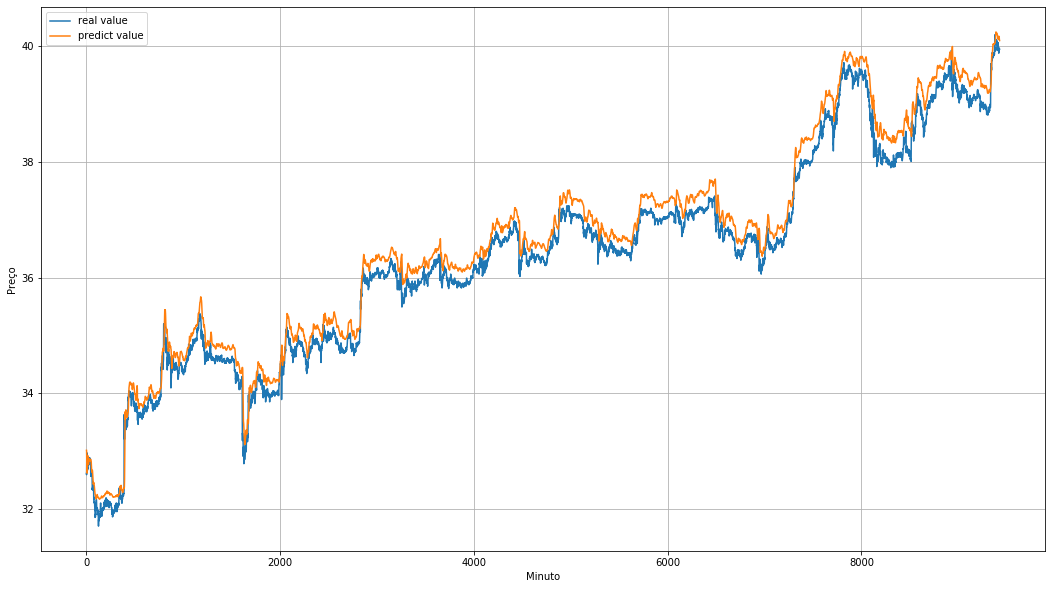

In [19]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0], "predict value")
plt.legend(loc='upper left')

# Predictions: Validation data

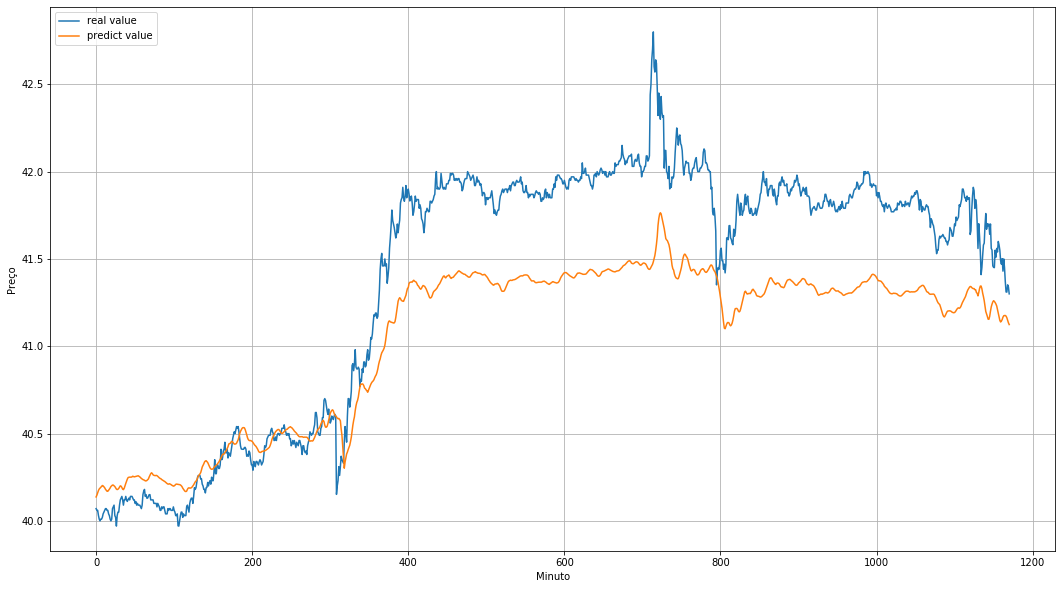

In [20]:
forecast_validation = model.predict(cross_validation_set, steps=VALIDATION_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0], "predict value")
plt.legend(loc='upper left')

# Predictions: Dev data

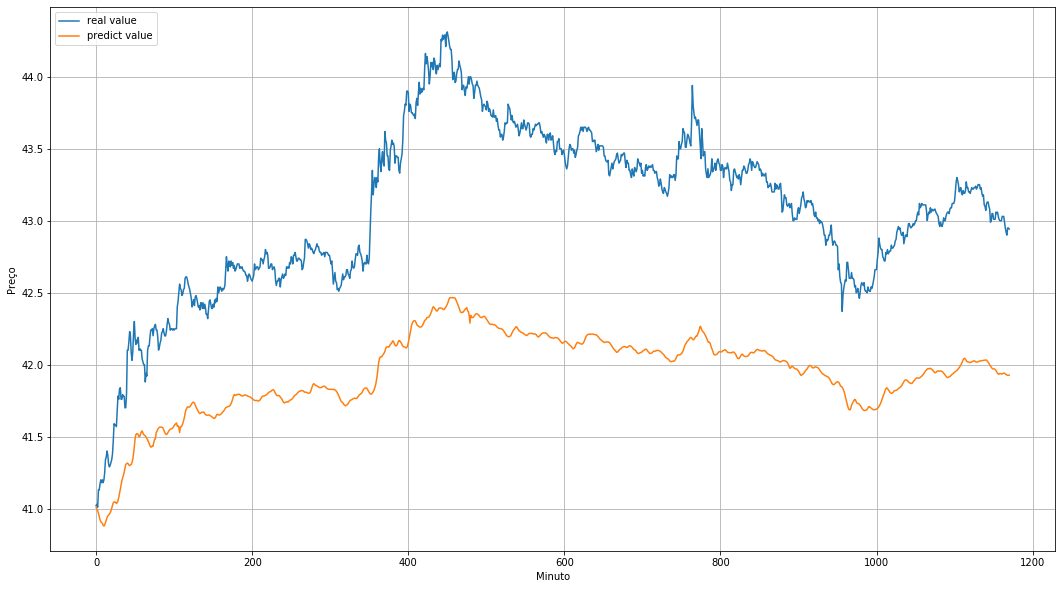

In [21]:
forecast_dev = model.predict(dev_set, steps=DEV_STEP)

plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_dev.shape[0]), labels_dev, "real value")
plot_series(np.arange(labels_dev.shape[0]), forecast_dev[:,0], "predict value")
plt.legend(loc='upper left')